<a href="https://colab.research.google.com/github/sunnypaajee/WA_Chat_Analyzer/blob/main/LSTMW2VEC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
from gensim.models import Word2Vec
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from sklearn.preprocessing import LabelEncoder
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.metrics import accuracy_score, confusion_matrix


In [34]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


In [5]:
!pip install -q kaggle
from google.colab import files

In [6]:
files.upload()



Saving kaggle (1).json to kaggle (1).json


{'kaggle (1).json': b'{"username":"harsimransingh17","key":"5db91c5247d7996d3ef2ae261651f1e7"}'}

In [7]:
! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/

cp: cannot stat 'kaggle.json': No such file or directory


In [8]:
! kaggle datasets download -d jp797498e/twitter-entity-sentiment-analysis

Dataset URL: https://www.kaggle.com/datasets/jp797498e/twitter-entity-sentiment-analysis
License(s): CC0-1.0
  0% 0.00/1.99M [00:00<?, ?B/s]
100% 1.99M/1.99M [00:00<00:00, 113MB/s]


In [9]:
!unzip twitter-entity-sentiment-analysis.zip

Archive:  twitter-entity-sentiment-analysis.zip
  inflating: twitter_training.csv    
  inflating: twitter_validation.csv  


In [10]:
df_train = pd.read_csv("twitter_training.csv")

df_train

,2401,Borderlands,Positive,"im getting on borderlands and i will murder you all ,"
0,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
1,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
2,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
3,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
4,2401,Borderlands,Positive,im getting into borderlands and i can murder y...
...,...,...,...,...
74676,9200,Nvidia,Positive,Just realized that the Windows partition of my...
74677,9200,Nvidia,Positive,Just realized that my Mac window partition is ...
74678,9200,Nvidia,Positive,Just realized the windows partition of my Mac ...
74679,9200,Nvidia,Positive,Just realized between the windows partition of...


In [11]:
df_test = pd.read_csv("twitter_validation.csv")

df_test

,3364,Facebook,Irrelevant,"I mentioned on Facebook that I was struggling for motivation to go for a run the other day, which has been translated by Tom’s great auntie as ‘Hayley can’t get out of bed’ and told to his grandma, who now thinks I’m a lazy, terrible person 🤣"
0,352,Amazon,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...
1,8312,Microsoft,Negative,@Microsoft Why do I pay for WORD when it funct...
2,4371,CS-GO,Negative,"CSGO matchmaking is so full of closet hacking,..."
3,4433,Google,Neutral,Now the President is slapping Americans in the...
4,6273,FIFA,Negative,Hi @EAHelp I’ve had Madeleine McCann in my cel...
...,...,...,...,...
994,4891,GrandTheftAuto(GTA),Irrelevant,⭐️ Toronto is the arts and culture capital of ...
995,4359,CS-GO,Irrelevant,tHIS IS ACTUALLY A GOOD MOVE TOT BRING MORE VI...
996,2652,Borderlands,Positive,Today sucked so it’s time to drink wine n play...
997,8069,Microsoft,Positive,Bought a fraction of Microsoft today. Small wins.


In [12]:
df_train.columns = ['Tweet ID', 'Entity', 'Sentiment', 'Tweet Content']
df_test.columns = ['Tweet ID', 'Entity', 'Sentiment', 'Tweet Content']


In [13]:
df_train

,Tweet ID,Entity,Sentiment,Tweet Content
0,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
1,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
2,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
3,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
4,2401,Borderlands,Positive,im getting into borderlands and i can murder y...
...,...,...,...,...
74676,9200,Nvidia,Positive,Just realized that the Windows partition of my...
74677,9200,Nvidia,Positive,Just realized that my Mac window partition is ...
74678,9200,Nvidia,Positive,Just realized the windows partition of my Mac ...
74679,9200,Nvidia,Positive,Just realized between the windows partition of...


In [14]:
df_train.drop(columns=['Tweet ID', 'Entity'], inplace=True)

In [15]:
df_test.drop(columns=['Tweet ID', 'Entity'], inplace=True)

In [16]:
df_train.isnull().sum()


Sentiment          0
Tweet Content    686
dtype: int64

In [17]:
df_train.dropna(inplace=True)

In [18]:
df_train.duplicated().sum()

df_train.drop_duplicates(inplace=True)

In [19]:
df_test.dropna(inplace=True)

In [20]:
df_test.duplicated().sum()

df_test.drop_duplicates(inplace=True)

In [21]:
twitter_sentiments = pd.concat([df_train,df_test],ignore_index=True)


In [22]:
twitter_sentiments

,Sentiment,Tweet Content
0,Positive,I am coming to the borders and I will kill you...
1,Positive,im getting on borderlands and i will kill you ...
2,Positive,im coming on borderlands and i will murder you...
3,Positive,im getting on borderlands 2 and i will murder ...
4,Positive,im getting into borderlands and i can murder y...
...,...,...
70761,Irrelevant,⭐️ Toronto is the arts and culture capital of ...
70762,Irrelevant,tHIS IS ACTUALLY A GOOD MOVE TOT BRING MORE VI...
70763,Positive,Today sucked so it’s time to drink wine n play...
70764,Positive,Bought a fraction of Microsoft today. Small wins.


In [23]:
twitter_sentiments.drop_duplicates(inplace=True)


In [24]:
print("Duplicated values in the new dataset" , twitter_sentiments.isnull().sum())

Duplicated values in the new dataset Sentiment        0
Tweet Content    0
dtype: int64


In [25]:
twitter_sentiments['Tweet_Length'] = twitter_sentiments['Tweet Content'].apply(len)

In [26]:
twitter_sentiments

,Sentiment,Tweet Content,Tweet_Length
0,Positive,I am coming to the borders and I will kill you...,51
1,Positive,im getting on borderlands and i will kill you ...,50
2,Positive,im coming on borderlands and i will murder you...,51
3,Positive,im getting on borderlands 2 and i will murder ...,57
4,Positive,im getting into borderlands and i can murder y...,53
...,...,...,...
70754,Neutral,♥️ Suikoden 2\n1️⃣ Alex Kidd in Miracle World\...,109
70755,Positive,Thank you to Matching funds Home Depot RW paym...,169
70757,Neutral,Late night stream with the boys! Come watch so...,197
70761,Irrelevant,⭐️ Toronto is the arts and culture capital of ...,281


In [27]:
twitter_sentiments['Sentiment'].value_counts()

Sentiment
Negative      21329
Positive      19270
Neutral       17281
Irrelevant    12371
Name: count, dtype: int64

In [28]:
twitter_sentiments['Sentiment'] = twitter_sentiments['Sentiment'].apply(lambda x: 'Neutral' if x.lower() in ['neutral', 'irrelevant'] else x)

In [29]:
twitter_sentiments['Sentiment'].value_counts()

Sentiment
Neutral     29652
Negative    21329
Positive    19270
Name: count, dtype: int64

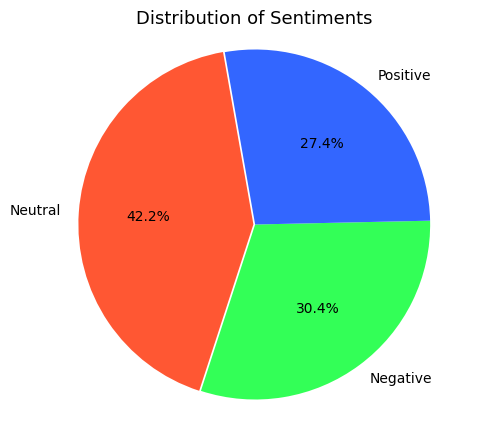

In [30]:
# Data Preparation
sentiments = twitter_sentiments['Sentiment'].value_counts()
labels = sentiments.index
sizes = sentiments.values
colors = ['#FF5733', '#33FF57', '#3366FF']
explode = (0.01, 0, 0)

# Plotting
plt.figure(figsize=(6,5))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.01f%%', startangle=100)
plt.title('Distribution of Sentiments', fontsize=13)
plt.axis('equal')

# Show plot
plt.show()

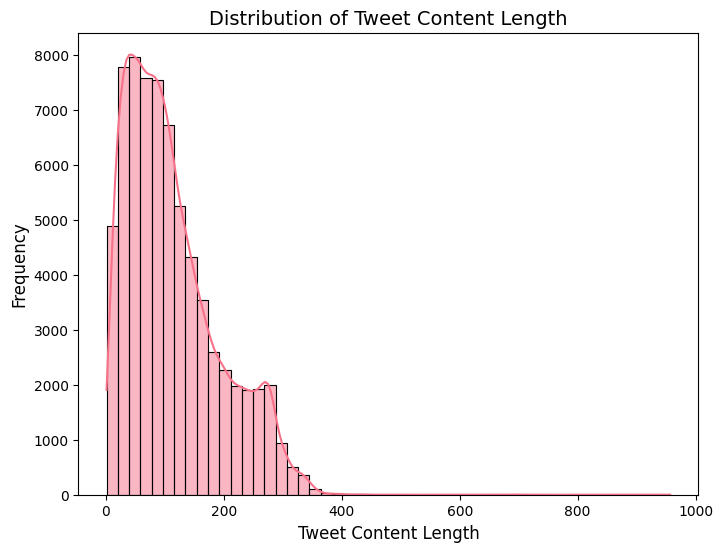

In [35]:
custom_palette = sns.color_palette("husl")

plt.figure(figsize=(8, 6))
sns.histplot(data=twitter_sentiments, x='Tweet_Length', bins=50, kde=True, color=custom_palette[0], edgecolor='black')

plt.xlabel('Tweet Content Length', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Distribution of Tweet Content Length', fontsize=14)
plt.show()

<ipython-input-36-fc4be00a3d9e>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=twitter_sentiments, x='Sentiment', y='Tweet_Length', palette=custom_palette, linewidth=1.5)
<ipython-input-36-fc4be00a3d9e>:2: UserWarning: The palette list has more values (6) than needed (3), which may not be intended.
  sns.violinplot(data=twitter_sentiments, x='Sentiment', y='Tweet_Length', palette=custom_palette, linewidth=1.5)


<Axes: xlabel='Sentiment', ylabel='Tweet_Length'>

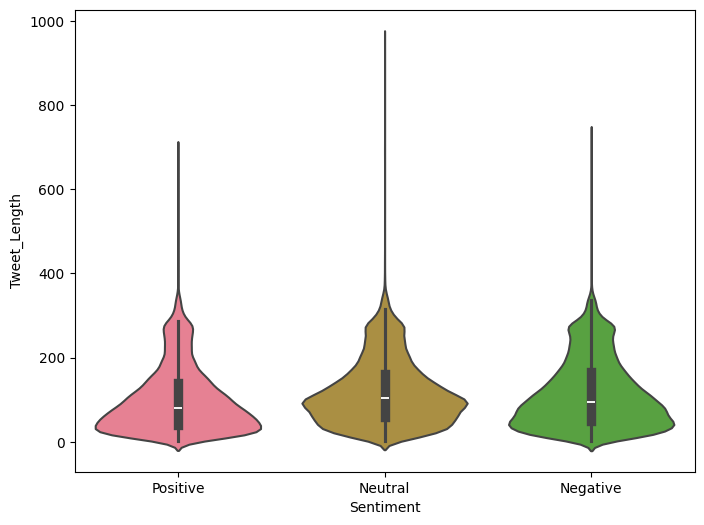

In [36]:
plt.figure(figsize=(8, 6))
sns.violinplot(data=twitter_sentiments, x='Sentiment', y='Tweet_Length', palette=custom_palette, linewidth=1.5)

In [37]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

def clean_text(text: str) -> str:
    text = text.lower()
    text = remove_special_characters_and_emojis(text)
    text = remove_urls(text)
    text = remove_mentions_and_hashtags(text)
    text = remove_html_tags(text)
    text = expand_contractions(text)
    text = remove_punctuation(text)
    text = remove_extra_whitespaces(text)
    text = tokenize_and_lemmatize(text)
    return text

def remove_urls(text: str) -> str:
    return re.sub(r'https*\S+', ' ', text)

def remove_mentions_and_hashtags(text: str) -> str:
    return re.sub(r'[@#]\S+', ' ', text)

def remove_html_tags(text: str) -> str:
    return re.sub('<.*?>', '', text)

def expand_contractions(text: str) -> str:
    contractions = {"don't": 'do not', "can't": 'cannot'}
    for contraction, expanded in contractions.items():
        text = text.replace(contraction, expanded)
    return text

def remove_punctuation(text: str) -> str:
    return re.sub('[%s]' % re.escape(string.punctuation), '', text)

def remove_extra_whitespaces(text: str) -> str:
    return re.sub('\s{2,}', ' ', text)

def remove_special_characters_and_emojis(text: str) -> str:
    special_char_pattern = r'[^a-zA-Z0-9\s]|[\U0001F600-\U0001F64F\U0001F300-\U0001F5FF\U0001F680-\U0001F6FF\U0001F700-\U0001F77F\U0001F780-\U0001F7FF\U0001F800-\U0001F8FF\U0001F900-\U0001F9FF\U0001FA00-\U0001FA6F\U0001FA70-\U0001FAFF\U00002702-\U000027B0\U000024C2-\U0001F251]'

    return re.sub(special_char_pattern, '', text)

def tokenize_and_lemmatize(text: str) -> str:
    lemmatizer = WordNetLemmatizer()
    words = word_tokenize(text)
    stopwords_set = set(stopwords.words('english'))
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words if word not in stopwords_set]
    return ' '.join(lemmatized_words)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [38]:
df_train['Sentiment'] = df_train['Sentiment'].apply(lambda x: 'Neutral' if x.lower() in ['neutral', 'irrelevant'] else x)
print(f"Sentiment value count: \n {df_train['Sentiment'].value_counts()}")
df_test['Sentiment'] = df_test['Sentiment'].apply(lambda x: 'Neutral' if x.lower() in ['neutral', 'irrelevant'] else x)
print(f"Sentiment value count: \n {df_test['Sentiment'].value_counts()}")

Sentiment value count: 
 Sentiment
Neutral     29394
Negative    21237
Positive    19137
Name: count, dtype: int64
Sentiment value count: 
 Sentiment
Neutral     456
Positive    276
Negative    266
Name: count, dtype: int64


In [39]:
df_train['cleaned_tweet'] = df_train['Tweet Content'].apply(clean_text)
df_test['cleaned_tweet'] = df_test['Tweet Content'].apply(clean_text)

In [40]:
df_train['encoded_sentiment'].value_counts()

KeyError: 'encoded_sentiment'

In [41]:
label_encoder = LabelEncoder()
df_train['encoded_sentiment'] = label_encoder.fit_transform(df_train['Sentiment'])
df_test['encoded_sentiment'] = label_encoder.transform(df_test['Sentiment'])

In [42]:
# Combine text from both datasets for Word2Vec training
twitter_sentiments = pd.concat([df_train['cleaned_tweet'], df_test['cleaned_tweet']])

# Tokenize tweets for Word2Vec
tokenized_tweets = [tweet.split() for tweet in twitter_sentiments]

# Train Word2Vec model
w2v_model = Word2Vec(tokenized_tweets, vector_size=100, window=5, min_count=1, sample=1e-3, epochs=10)

In [43]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(twitter_sentiments)

# Convert tweets to sequences
train_sequences = tokenizer.texts_to_sequences(df_train['cleaned_tweet'])
test_sequences = tokenizer.texts_to_sequences(df_test['cleaned_tweet'])

# Pad sequences
X_train = pad_sequences(train_sequences, maxlen=100)
X_test = pad_sequences(test_sequences, maxlen=100)

# Prepare labels
y_train = df_train['encoded_sentiment']
y_test = df_test['encoded_sentiment']

In [44]:
model = Sequential()
model.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=100))
model.add(LSTM(128, return_sequences=True))
model.add(LSTM(128))
model.add(Dense(3, activation='softmax')) # 3 units for 'Positive', 'Negative', 'Neutral'

# Compile the model
model.compile(optimizer='adam' , metrics=['accuracy'])
model.compile(optimizer='adam' ,loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit(X_train, y_train, epochs=35, batch_size=128, validation_split=0.2)


Epoch 1/35
437/437 [==============================] - 442s 991ms/step - loss: 0.6536 - accuracy: 0.7093 - val_loss: 1.3503 - val_accuracy: 0.5456
Epoch 2/35
437/437 [==============================] - 406s 929ms/step - loss: 0.2540 - accuracy: 0.9025 - val_loss: 1.5654 - val_accuracy: 0.5343
Epoch 3/35
407/437 [==========================>...] - ETA: 26s - loss: 0.1481 - accuracy: 0.9433

In [2]:
|plt.figure(figsize=(6, 4))
plt.plot(history.history['accuracy'], label='Training Accuracy', color='blue')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='red')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot training & validation loss values
plt.figure(figsize=(6, 4))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='red')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

SyntaxError: invalid syntax (<ipython-input-2-7fc95dc46aa2>, line 1)